## 导入相应的包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as ppf
import warnings##忽略警告
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder#标签编码
from sklearn.preprocessing import RobustScaler, StandardScaler#去除异常值与数据标准化
from sklearn.pipeline import Pipeline, make_pipeline#构建管道
from scipy.stats import skew#偏度
from sklearn.impute import SimpleImputer


## 检视原数据

In [4]:
train = pd.read_csv("train.csv")

In [5]:
test = pd.read_csv("test.csv")

In [6]:
train.head()#默认显示前五行

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## 数据探索性分析 pandas_profiling

In [8]:
ppf.ProfileReport(train)

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

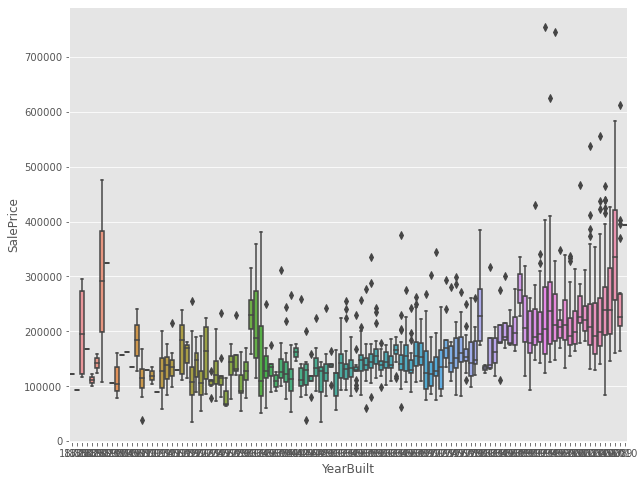

In [9]:
plt.figure(figsize=(10,8))
sns.boxplot(train.YearBuilt, train.SalePrice)##箱型图看异常值，离群点

(0.0, 800000.0)

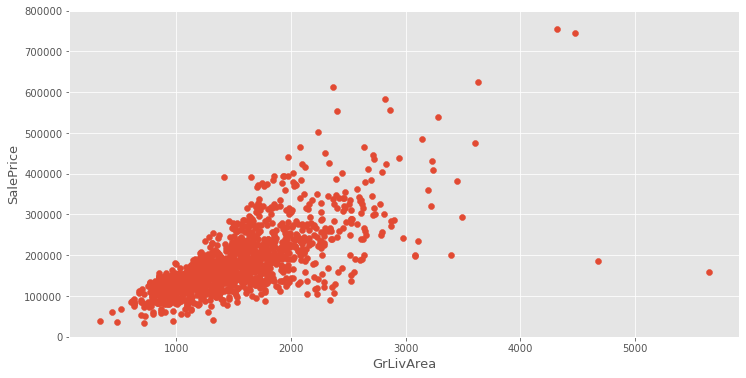

In [10]:
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)##观察存在线型的关系
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

In [11]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)#pandas 里面的条件索引

In [12]:
full = pd.concat([train,test],ignore_index=True)

In [13]:
full.drop("Id",axis=1,inplace=True)

In [14]:
full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


# 数据清洗--空值填充、空值的删除，不处理

In [16]:
##查看缺失值，并且缺失的个数要从高到低排序

In [17]:
miss = full.isnull().sum()#统计出空值的个数

In [18]:
miss[miss>0].sort_values(ascending=True)#由低到高排好序

Electrical         1
GarageArea         1
GarageCars         1
Exterior1st        1
Exterior2nd        1
KitchenQual        1
SaleType           1
TotalBsmtSF        1
BsmtFinSF1         1
BsmtUnfSF          1
BsmtFinSF2         1
Utilities          2
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
MSZoning           4
MasVnrArea        23
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtExposure      82
BsmtCond          82
GarageType       157
GarageCond       159
GarageQual       159
GarageFinish     159
GarageYrBlt      159
LotFrontage      486
FireplaceQu     1420
SalePrice       1459
Fence           2346
Alley           2719
MiscFeature     2812
PoolQC          2908
dtype: int64

In [19]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   int64  
 1   MSZoning       2913 non-null   object 
 2   LotFrontage    2431 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2917 non-null   object 
 7   LandContour    2917 non-null   object 
 8   Utilities      2915 non-null   object 
 9   LotConfig      2917 non-null   object 
 10  LandSlope      2917 non-null   object 
 11  Neighborhood   2917 non-null   object 
 12  Condition1     2917 non-null   object 
 13  Condition2     2917 non-null   object 
 14  BldgType       2917 non-null   object 
 15  HouseStyle     2917 non-null   object 
 16  OverallQual    2917 non-null   int64  
 17  OverallCond    2917 non-null   int64  
 18  YearBuil

## 空值的填充与删除

对字符类型的进行填充

In [20]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None",inplace=True)

对数值类型的进行填充

In [21]:
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True)

对lotfrontage的空值进行填充（用这一列的均值）

In [22]:
full["LotFrontage"].fillna(np.mean(full["LotFrontage"]),inplace=True)

对这些列进行众数填充

In [23]:
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)

## 数据预处理--字符变成数值型这是很重要的

将一些数字特征转换为类别特征。使用LabelEncoder和get_dummies来实现这些功能。

In [25]:
full["MSZoning"].mode()[0]

'RL'

In [26]:
for col in cols2:
    full[col]=full[col].astype(str)##astype来进行数据转换成字符串类型

In [27]:
lab = LabelEncoder()

In [28]:
full["Alley"] = lab.fit_transform(full.Alley)
full["PoolQC"] = lab.fit_transform(full.PoolQC)
full["MiscFeature"] = lab.fit_transform(full.MiscFeature)
full["Fence"] = lab.fit_transform(full.Fence)
full["FireplaceQu"] = lab.fit_transform(full.FireplaceQu)
full["GarageQual"] = lab.fit_transform(full.GarageQual)
full["GarageCond"] = lab.fit_transform(full.GarageCond)
full["GarageFinish"] = lab.fit_transform(full.GarageFinish)
full["GarageYrBlt"] = full["GarageYrBlt"].astype(str)
full["GarageYrBlt"] = lab.fit_transform(full.GarageYrBlt)
full["GarageType"] = lab.fit_transform(full.GarageType)
full["BsmtExposure"] = lab.fit_transform(full.BsmtExposure)
full["BsmtCond"] = lab.fit_transform(full.BsmtCond)
full["BsmtQual"] = lab.fit_transform(full.BsmtQual)
full["BsmtFinType2"] = lab.fit_transform(full.BsmtFinType2)
full["BsmtFinType1"] = lab.fit_transform(full.BsmtFinType1)
full["MasVnrType"] = lab.fit_transform(full.MasVnrType)
full["BsmtFinType1"] = lab.fit_transform(full.BsmtFinType1)

In [29]:
full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,1,Reg,Lvl,AllPub,Inside,...,0,3,4,1,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,1,Reg,Lvl,AllPub,FR2,...,0,3,4,1,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,1,IR1,Lvl,AllPub,Inside,...,0,3,4,1,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,1,IR1,Lvl,AllPub,Corner,...,0,3,4,1,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,1,IR1,Lvl,AllPub,FR2,...,0,3,4,1,0,12,2008,WD,Normal,250000.0


In [30]:
full["MSZoning"] = lab.fit_transform(full.MSZoning)
full["BsmtFullBath"] = lab.fit_transform(full.BsmtFullBath)
full["BsmtHalfBath"] = lab.fit_transform(full.BsmtHalfBath)
full["Utilities"] = lab.fit_transform(full.Utilities)
full["Functional"] = lab.fit_transform(full.Functional)
full["Electrical"] = lab.fit_transform(full.Electrical)
full["KitchenQual"] = lab.fit_transform(full.KitchenQual)
full["SaleType"] = lab.fit_transform(full.SaleType)
full["Exterior1st"] = lab.fit_transform(full.Exterior1st)
full["Exterior2nd"] = lab.fit_transform(full.Exterior2nd)

In [31]:
full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,Pave,1,Reg,Lvl,0,Inside,...,0,3,4,1,0,2,2008,8,Normal,208500.0
1,20,3,80.0,9600,Pave,1,Reg,Lvl,0,FR2,...,0,3,4,1,0,5,2007,8,Normal,181500.0
2,60,3,68.0,11250,Pave,1,IR1,Lvl,0,Inside,...,0,3,4,1,0,9,2008,8,Normal,223500.0
3,70,3,60.0,9550,Pave,1,IR1,Lvl,0,Corner,...,0,3,4,1,0,2,2006,8,Abnorml,140000.0
4,60,3,84.0,14260,Pave,1,IR1,Lvl,0,FR2,...,0,3,4,1,0,12,2008,8,Normal,250000.0


In [32]:
full.drop("SalePrice",axis=1,inplace=True)##删除

In [89]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder#标签编码
from sklearn.preprocessing import RobustScaler, StandardScaler#去除异常值与数据标准化
from sklearn.pipeline import Pipeline, make_pipeline#构建管道
from scipy.stats import skew#偏度
from sklearn.impute import SimpleImputer


#管道建设

In [35]:
##自己写一个转换函数
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    ##对三个年份来进行一个标签编码,这里可以随便自己添加
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        X["BldgType"] = lab.fit_transform(X["BldgType"])
        
        return X

In [36]:
#转换函数
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):#偏度
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])#而是去除了包含了对象数据类型，取出来绝大部分是数值型
        skewness = X_numeric.apply(lambda x: skew(x))#匿名函数，做成字典的形式
        skewness_features = skewness[abs(skewness) >= self.skew].index#通过条件来涮选出skew>=0.5的索引的条件，取到了全部数据，防止数据的丢失
        X[skewness_features] = np.log1p(X[skewness_features])#求对数，进一步让他更符合正态分布
        X = pd.get_dummies(X)##一键独热，独热编码
        return X

In [37]:
# 构建管道
pipe = Pipeline([##构建管道的意思
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=2)),
    ])

In [38]:
# 保存原来的数据以备后用，为了防止写错
full2 = full.copy()

In [39]:
pipeline_data = pipe.fit_transform(full2)

In [40]:
pipeline_data.shape

(2917, 178)

In [41]:
pipeline_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,Utilities,BldgType,OverallQual,OverallCond,YearBuilt,...,CentralAir_Y,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,3,65.0,9.042040,1,0.0,0.0,7,5,110,...,1,0,0,1,0,0,0,0,1,0
1,20,3,80.0,9.169623,1,0.0,0.0,6,8,83,...,1,0,0,1,0,0,0,0,1,0
2,60,3,68.0,9.328212,1,0.0,0.0,7,5,108,...,1,0,0,1,0,0,0,0,1,0
3,70,3,60.0,9.164401,1,0.0,0.0,7,5,25,...,1,0,0,1,1,0,0,0,0,0
4,60,3,84.0,9.565284,1,0.0,0.0,8,5,107,...,1,0,0,1,0,0,0,0,1,0


In [42]:
n_train=train.shape[0]#训练集的行数
X = pipeline_data[:n_train]#取出处理之后的训练集
test_X = pipeline_data[n_train:]#取出n_train后的数据作为测试集
y= train.SalePrice
X_scaled = StandardScaler().fit(X).transform(X)#做转换
y_log = np.log(train.SalePrice)##这里要注意的是，更符合正态分布
#得到测试集
test_X_scaled = StandardScaler().fit_transform(test_X)

特征的选择--基于特征重要性图来选择

In [43]:
from sklearn.linear_model import Lasso##运用算法来进行训练集的得到特征的重要性，特征选择的一个作用是，wrapper基础模型
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001)

In [44]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=pipeline_data.columns)#索引和重要性做成dataframe形式

In [45]:
FI_lasso.sort_values("Feature Importance",ascending=False)#由高到低进行排序

,Feature Importance
GrLivArea,0.124635
OverallQual,0.070733
YearBuilt,0.054597
TotalBsmtSF,0.045554
OverallCond,0.044664
...,...
Neighborhood_MeadowV,-0.013847
Neighborhood_OldTown,-0.013857
Neighborhood_IDOTRR,-0.014939
CentralAir_N,-0.016364


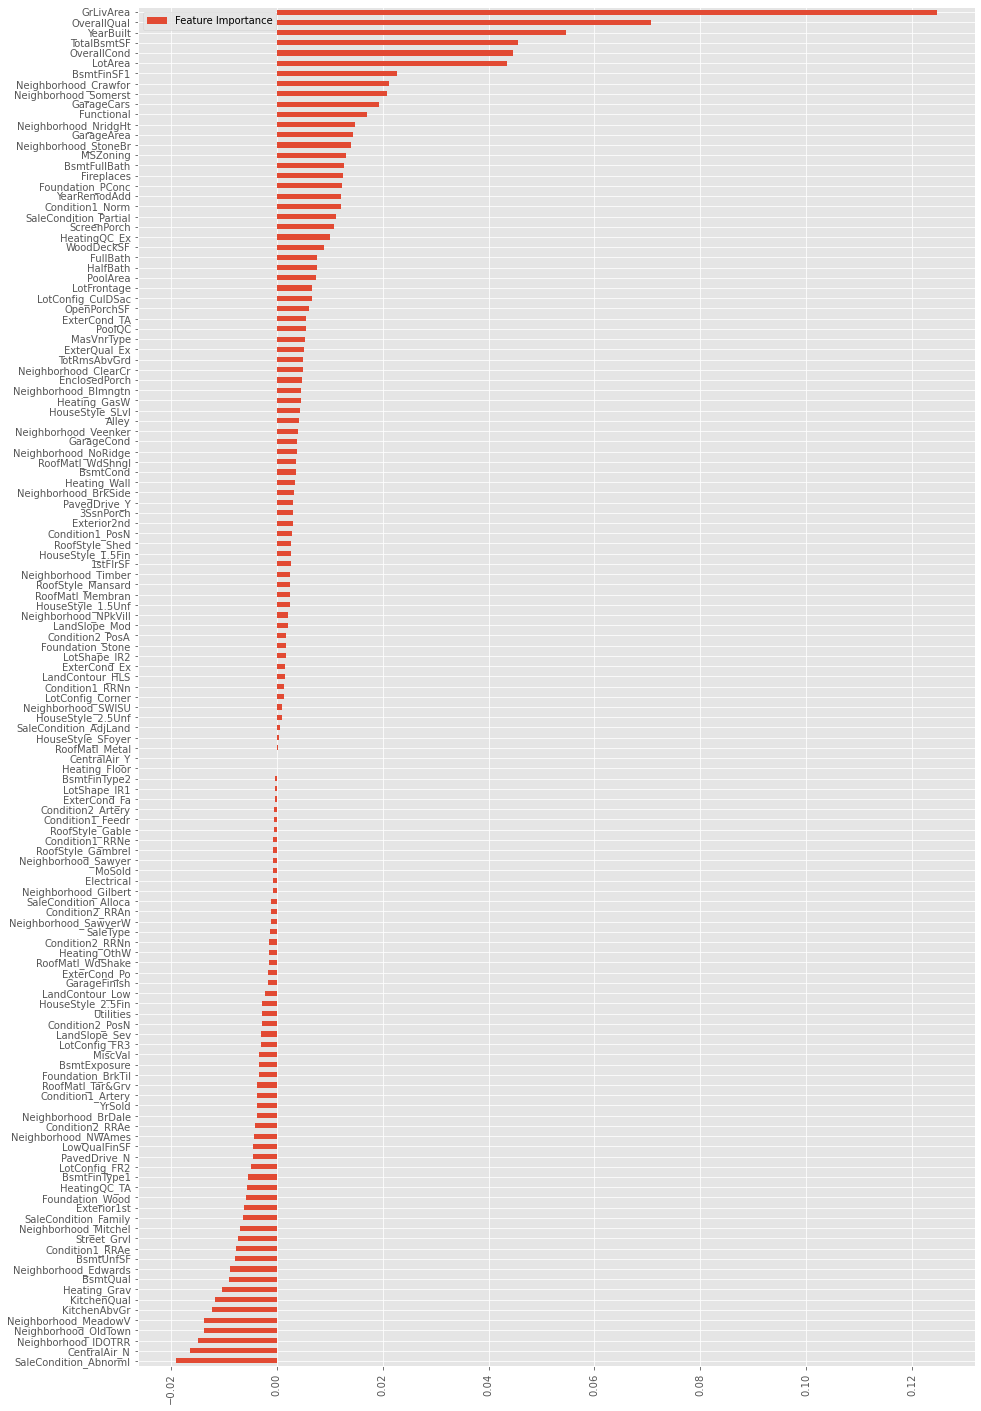

In [46]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()##画图显示

In [47]:
class add_feature(BaseEstimator, TransformerMixin):#自己定义转换函数--fit_transform由自己定义
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

In [48]:
pipe = Pipeline([#把后面的东西加到管道里面来
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=4)),
    ])

In [49]:
pipe

Pipeline(steps=[('labenc', labelenc()),
                ('add_feature', add_feature(additional=2)),
                ('skew_dummies', skew_dummies(skew=4))])

In [50]:
n_train=train.shape[0]#训练集的行数
X = pipeline_data[:n_train]#取出处理之后的训练集
test_X = pipeline_data[n_train:]#取出n_train后的数据作为测试集
y= train.SalePrice
X_scaled = StandardScaler().fit(X).transform(X)#做转换
y_log = np.log(train.SalePrice)##这里要注意的是，更符合正态分布
#得到测试集
test_X_scaled = StandardScaler().fit_transform(test_X)

# 模型的构建

In [51]:
from sklearn.tree import DecisionTreeRegressor#导入模型

In [52]:
model = DecisionTreeRegressor()

In [53]:
model1 =model.fit(X_scaled,y_log)

## 模型训练好了后就对test进行预测

In [54]:
predict = np.exp(model1.predict(test_X_scaled))##np.exp是对上面的对数变换之后的反变换

In [55]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':predict})
result.to_csv("submission1.csv",index=False)

In [57]:
import sys
!{sys.executable} -m pip install xgboost

## 模型的堆叠与集成并且选择最优参数，模型和评估方式

In [90]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [59]:
#定义交叉验证的策略，以及评估函数
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [60]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [61]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 521382774552.819153, 479723926561.0452
Ridge: 0.118922, 0.0076
Lasso: 0.118918, 0.0065
RF: 0.139574, 0.0047
GBR: 0.122992, 0.0076
SVR: 0.178998, 0.0133
LinSVR: 1.237881, 0.4902
Ela: 0.116368, 0.0070
SGD: 6.553382, 2.5244
Bay: 0.117589, 0.0066
Ker: 0.114100, 0.0081
Extra: 0.132039, 0.0121
Xgb: 0.136112, 0.0086


In [62]:
##定义交叉方式，先指定模型后指定参数，方便测试多个模型，网格交叉验证
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [63]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})

{'alpha': 0.0009, 'max_iter': 10000} 0.11556653958734706
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.116894        0.001659
1  {'alpha': 0.0005, 'max_iter': 10000}         0.116575        0.001644
2  {'alpha': 0.0007, 'max_iter': 10000}         0.116031        0.001612
3  {'alpha': 0.0006, 'max_iter': 10000}         0.116296        0.001630
4  {'alpha': 0.0009, 'max_iter': 10000}         0.115567        0.001574
5  {'alpha': 0.0008, 'max_iter': 10000}         0.115784        0.001591


In [64]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 90} 0.11753054517450434
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.118089        0.001621
1  {'alpha': 40}         0.117994        0.001607
2  {'alpha': 45}         0.117912        0.001595
3  {'alpha': 50}         0.117841        0.001583
4  {'alpha': 55}         0.117778        0.001573
5  {'alpha': 60}         0.117724        0.001564
6  {'alpha': 65}         0.117678        0.001555
7  {'alpha': 70}         0.117638        0.001547
8  {'alpha': 80}         0.117575        0.001533
9  {'alpha': 90}         0.117531        0.001521


In [65]:
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 14, 'epsilon': 0.009, 'gamma': 0.0003, 'kernel': 'rbf'} 0.1160044035925215
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.116142   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.117301   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.116095   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.117325   
4   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.116083   
5   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.117368   
6   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.116037   
7   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.117382   
8   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.116050   
9   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.117414   
10  {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.116014   
11  {'C': 13, 'epsilon': 0.009,

In [66]:
param_grid={'alpha':[0.2,0.3,0.4,0.5], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1,1.2]}#定义好的参数，用字典来表示
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.5, 'coef0': 1.2, 'degree': 3, 'kernel': 'polynomial'} 0.12632057844254363
                                               params  mean_test_score  \
0   {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.146873   
1   {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.133871   
2   {'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'ker...         0.128384   
3   {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.147488   
4   {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.133296   
5   {'alpha': 0.3, 'coef0': 1.2, 'degree': 3, 'ker...         0.127281   
6   {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.148416   
7   {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.133151   
8   {'alpha': 0.4, 'coef0': 1.2, 'degree': 3, 'ker...         0.126669   
9   {'alpha': 0.5, 'coef0': 0.8, 'degree': 3, 'ker...         0.149500   
10  {'alpha': 0.5, 'coef0': 1, 'degree': 3, 'kerne...         0.133233   
11  {'alpha': 0.5, 'coef0'

In [67]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

{'alpha': 0.005, 'l1_ratio': 0.7, 'max_iter': 10000} 0.11375780517257136
                                               params  mean_test_score  \
0   {'alpha': 0.0005, 'l1_ratio': 0.08, 'max_iter'...         0.118846   
1   {'alpha': 0.0005, 'l1_ratio': 0.1, 'max_iter':...         0.118770   
2   {'alpha': 0.0005, 'l1_ratio': 0.3, 'max_iter':...         0.118065   
3   {'alpha': 0.0005, 'l1_ratio': 0.5, 'max_iter':...         0.117526   
4   {'alpha': 0.0005, 'l1_ratio': 0.7, 'max_iter':...         0.117130   
5   {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.118682   
6   {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.118557   
7   {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.117572   
8   {'alpha': 0.0008, 'l1_ratio': 0.5, 'max_iter':...         0.116898   
9   {'alpha': 0.0008, 'l1_ratio': 0.7, 'max_iter':...         0.116408   
10  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.117295   
11  {'alpha': 0.004, 'l1_ratio': 0.1, '

In [68]:
##定义加权平均值，就相当于自己写fit_transform（）
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod##模型的个数
        self.weight = weight##权重
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # 针对于每一个数据点，单一的模型是乘以权重，然后加起来
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [69]:
#指定每一个算法的参数
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

In [70]:
##6个权重
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2

In [71]:
weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])

In [72]:
rmse_cv(weight_avg,X_scaled,y_log),  rmse_cv(weight_avg,X_scaled,y_log).mean()##计算出交叉验证的均值

(array([0.11820394, 0.1260094 , 0.1232113 , 0.10292816, 0.11264986]),
 0.11660053262723793)

## <font color=green>模型的堆叠</font>

In [73]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model#元模型
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)##这就是堆叠的最大特征进行了几折的划分
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):#返回的是索引和模型本身
            for train_index, val_index in self.kf.split(X,y):##返回的是数据本省
                renew_model = clone(model)##模型的复制
                renew_model.fit(X[train_index], y[train_index])#对数据进行训练
                self.saved_model[i].append(renew_model)##把模型添加进去
                oof_train[val_index,i] = renew_model.predict(X[val_index])##用来预测验证集
        
        self.meta_model.fit(oof_train,y)#元模型
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) ##得到的是整个测试集
        return self.meta_model.predict(whole_test)#返回的是利用元模型来对整个测试集进行预测
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))##初始化为0
        test_single = np.zeros((test_X.shape[0],5))##初始化为0 
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):##i是模型
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):##j是所有划分好的的数据
                clone_model = clone(model)##克隆模块，相当于把模型复制一下
                clone_model.fit(X[train_index],y[train_index])##把分割好的数据进行训练
                oof[val_index,i] = clone_model.predict(X[val_index])##对验证集进行预测
                test_single[:,j] = clone_model.predict(test_X)##对测试集进行预测
            test_mean[:,i] = test_single.mean(axis=1)##测试集算好均值
        return oof, test_mean

In [91]:
##经过预处理之后才能放到堆叠的模型里面去计算
a = SimpleImputer().fit_transform(X_scaled)#相当于x
b = SimpleImputer().fit_transform(y_log.values.reshape(-1,1)).ravel()#相当于y

In [78]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)#定义了第一层的和第二层的模型

In [79]:
print(rmse_cv(stack_model,a,b))##运用了评估函数
print(rmse_cv(stack_model,a,b).mean())

[0.1062599  0.12083193 0.12267102 0.10277685 0.11180054]
0.11286804628079353


In [80]:
X_train_stack, X_test_stack = stack_model.get_oof(a,b,test_X_scaled)#将数据进行变换

In [81]:
X_train_stack.shape, a.shape

((1458, 6), (1458, 178))

In [82]:
X_train_add = np.hstack((a,X_train_stack))
X_test_add = np.hstack((test_X_scaled,X_test_stack))
X_train_add.shape, X_test_add.shape

((1458, 184), (1459, 184))

In [83]:
print(rmse_cv(stack_model,X_train_add,b))
print(rmse_cv(stack_model,X_train_add,b).mean())

[0.09619498 0.10344875 0.10607794 0.08994562 0.10016211]
0.0991658816650974


In [84]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [85]:
stack_model.fit(a,b)#模型进行训练

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, kernel='polynomial'),
         mod=[Lasso(alpha=0.0005, max_iter=10000), Ridge(alpha=60),
              SVR(C=13, epsilon=0.009, gamma=0.0004),
              KernelRidge(alpha=0.2, coef0=0.8, kernel='polynomial'),
              ElasticNet(alpha=0.005, l1_ratio=0.08, max_iter=10000),
              BayesianRidge()])

In [86]:
pred = np.exp(stack_model.predict(test_X_scaled))#进行预测

In [87]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)